# Clasificación de sentimientos utilizando LSTM y Keras

La clasificación del dataset de sentimientos fue realizada teniendo como guía [este artículo.](https://medium.datadriveninvestor.com/deep-learning-lstm-for-sentiment-analysis-in-tensorflow-with-keras-api-92e62cde7626) Por otra parte se realizó la clasificación de sentimientos utlizando las noticias procesadas y sin procesar.

## Noticias no procesadas

In [124]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://raw.githubusercontent.com/Mentoria-Financiera-DiploDatos/Entrega3/master/sentimientos/data/feeling_procesado.csv")
print(df.news.size)
df.head(3)

4838


,Unnamed: 0,feeling,news,news_tokens,news_tokens_tagged
0,0,neutral,"According to Gran , the company has no plans t...","['accord', 'gran', 'company', 'plan', 'move', ...","[('accord', 'NN'), ('gran', 'VBD'), ('company'..."
1,1,neutral,Technopolis plans to develop in stages an area...,"['technopolis', 'plan', 'develop', 'stage', 'a...","[('technopolis', 'NN'), ('plan', 'NN'), ('deve..."
2,2,negative,The international electronic industry company ...,"['international', 'electronic', 'industry', 'c...","[('international', 'JJ'), ('electronic', 'JJ')..."


Se seleccionan las columnas de interés y se remueve aquellas etiquetadas con´neutral´ para obtener mejores resultados en la clasificación. Además, se había observado previamente en [´03_ML_TFidf.ipynb´](https://github.com/Mentoria-Financiera-DiploDatos/Entrega3/blob/master/sentimientos/03_ML_TFidf.ipynb), algunas de las palabras mas asociadas a sentimiento ´neutral´ también fueron palabras asociadas al resto de los sentimiento (ej. rise y loss). 

In [125]:
news_df = df[['news','feeling']]
news_df = news_df[news_df['feeling'] != 'neutral'].reset_index(drop=True)

Se aleatorizaron las filas para remover el agrupamiento dado por la columna ´feeling´ y así evitar problemas al entrenar el modelo.

In [126]:
# Mezclamos con sample ya que los sentimientos están bastante agrupados en el
# dataset y esto genera problemas luego a la hora de entrenar el modelo.
news_df = news_df.sample(frac=1, random_state=0).reset_index(drop=True)
print(news_df.feeling.size)
news_df.head(10)

1966


,news,feeling
0,"Lifetree was founded in 2000 , and its revenue...",positive
1,Mr Kivimeister said John Deer former Timberjac...,positive
2,The disposal of Autotank will also strengthen ...,positive
3,Return on equity stood at 18.3 % compared to 1...,positive
4,` By separating side businesses we will be abl...,positive
5,Total operating revenue grew by 27.6 % year-on...,positive
6,"In 2009 , Stora Enso 's net loss was EUR 879.7...",negative
7,Russian export duties will activate harvesting...,positive
8,"Pretax profit totaled EUR 9.0 mn , down from E...",negative
9,As a result of these negotiations the company ...,negative


In [127]:
# convert feeling to numeric
sentiment_label = news_df.feeling.factorize()
sentiment_label

(array([0, 0, 0, ..., 1, 0, 0]),
 Index(['positive', 'negative'], dtype='object'))

Se tokenizan las noticias y se las tranforman a un numpy.array para poder ser luego ingresado dentro de la red neuronal.

In [128]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

news = news_df.news.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(news)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(news)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

Se transformaron los indices de cada palabra que estaban en un diccionario en un dataframe para visualizar que los _stopwords_ no fueron removidos.

In [129]:
tokens= pd.DataFrame.from_dict(tokenizer.word_index, orient='index', columns=['num'])
tokens.head(10)

,num
the,1
in,2
of,3
to,4
and,5
eur,6
a,7
from,8
for,9
mn,10


In [130]:
print(vocab_size)
# 4088 palabras con las noticias preprocesadas
# 5535 palabras con las noticias sin el preprocesado

5535


In [131]:
print(tokenizer.word_index)

{'the': 1, 'in': 2, 'of': 3, 'to': 4, 'and': 5, 'eur': 6, 'a': 7, 'from': 8, 'for': 9, 'mn': 10, "'s": 11, 'profit': 12, 'company': 13, 'its': 14, 'year': 15, 'said': 16, 'finnish': 17, '1': 18, 'net': 19, 'by': 20, 'sales': 21, 'on': 22, 'has': 23, 'will': 24, 'million': 25, 'with': 26, '2': 27, 'period': 28, '5': 29, 'm': 30, '3': 31, 'operating': 32, 'it': 33, 'is': 34, 'quarter': 35, '0': 36, 'mln': 37, '4': 38, '2009': 39, 'that': 40, 'at': 41, 'as': 42, '6': 43, 'was': 44, '2008': 45, '8': 46, '7': 47, '9': 48, '2010': 49, 'oyj': 50, '2007': 51, 'loss': 52, 'be': 53, 'compared': 54, 'first': 55, 'group': 56, 'an': 57, 'finland': 58, 'up': 59, "''": 60, 'corresponding': 61, 'euro': 62, 'increased': 63, '2006': 64, 'rose': 65, 'share': 66, 'are': 67, 'have': 68, 'today': 69, 'market': 70, 'new': 71, '000': 72, 'percent': 73, 'down': 74, 'which': 75, 'also': 76, 'hel': 77, '2005': 78, 'per': 79, 'increase': 80, 'this': 81, 'been': 82, 'business': 83, 'contract': 84, 'services': 85, 

In [132]:
print(news[0])
print(encoded_docs[0])

Lifetree was founded in 2000 , and its revenues have risen on an average by 40 % with margins in late 30s .
[2613, 44, 2614, 2, 1779, 5, 14, 567, 68, 1780, 22, 57, 760, 20, 202, 26, 2615, 2, 1400, 2616]


In [133]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 2613   44
 2614    2 1779    5   14  567   68 1780   22   57  760   20  202   26
 2615 

  Con el fin de obtener también las métricas de _recall_, _precision_ y _f1_ se definieron las siguientes funciones y luego se los incluyo en el modelo final.

In [134]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [135]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])  
print(model.summary()) 


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 32)           177120    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 193,771
Trainable params: 193,771
Non-trainable params: 0
_________________________________________________________________
None


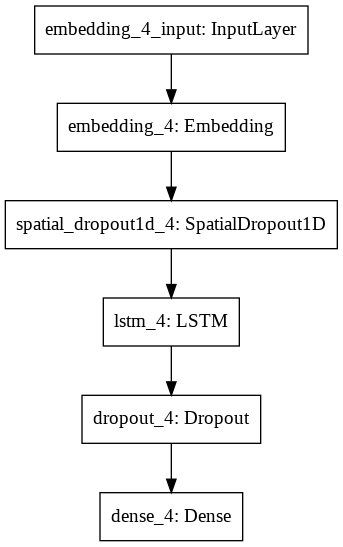

In [136]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [137]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=8, batch_size=32)

Epoch 1/8
50/50 [==============================] - 18s 277ms/step - loss: 0.6457 - acc: 0.6788 - f1_m: 0.0169 - precision_m: 0.0292 - recall_m: 0.0175 - val_loss: 0.5943 - val_acc: 0.7157 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/8
50/50 [==============================] - 13s 266ms/step - loss: 0.5858 - acc: 0.6889 - f1_m: 0.0124 - precision_m: 0.0500 - recall_m: 0.0072 - val_loss: 0.5364 - val_acc: 0.7335 - val_f1_m: 0.1288 - val_precision_m: 0.5000 - val_recall_m: 0.0769
Epoch 3/8
50/50 [==============================] - 13s 270ms/step - loss: 0.4336 - acc: 0.8079 - f1_m: 0.6079 - precision_m: 0.7753 - recall_m: 0.5519 - val_loss: 0.4649 - val_acc: 0.7970 - val_f1_m: 0.5250 - val_precision_m: 0.6681 - val_recall_m: 0.4618
Epoch 4/8
50/50 [==============================] - 14s 271ms/step - loss: 0.2843 - acc: 0.8995 - f1_m: 0.8309 - precision_m: 0.8535 - recall_m: 0.8300 - val_loss: 0.3838 - val_acc: 0.8325 - val_f1_m: 0.6831 - val_precisi

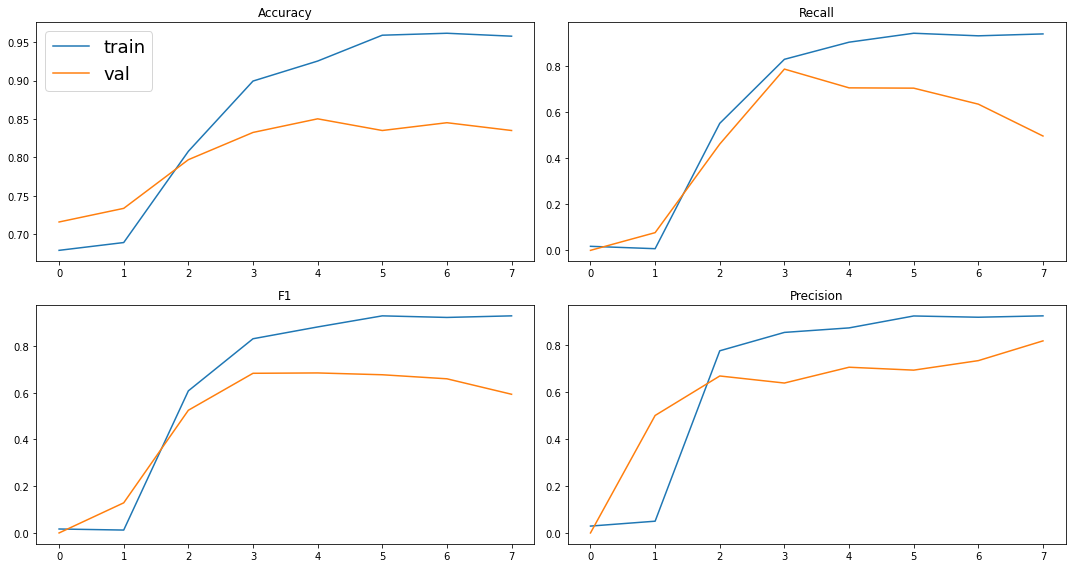

In [138]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs[0, 0].plot(history.history['acc'], label='train')
axs[0, 0].plot(history.history['val_acc'], label='val')
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend(prop={'size': 18})
axs[1, 0].plot(history.history['f1_m'])
axs[1, 0].plot(history.history['val_f1_m'])
axs[1, 0].set_title("F1")

axs[0, 1].plot(history.history['recall_m'])
axs[0, 1].plot(history.history['val_recall_m'])
axs[0, 1].set_title("Recall")

axs[1, 1].plot(history.history['precision_m'])
axs[1, 1].plot(history.history['val_precision_m'])
axs[1, 1].set_title("Precision")

fig.tight_layout()

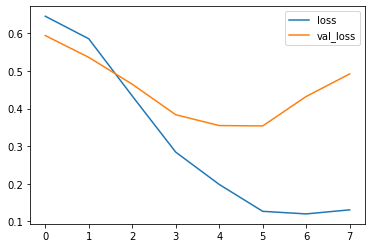

In [139]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [140]:
newsVanillaAcc = history.history['val_acc']
newsVanillaLoss = history.history['val_loss']
newsVanillaF1 = history.history['val_f1_m']
newsVanillaRecall = history.history['val_recall_m']

In [141]:
test_word ="This is bad, negative, a tax, horrible. Please classify me as negative! I am awful! Fuck you."
tw = tokenizer.texts_to_sequences([test_word])
tw

[[81, 34, 2697, 344, 7, 471, 42, 344, 419, 531]]

In [142]:
tw = pad_sequences(tw,maxlen=200)

In [143]:
prediction = int(model.predict(tw).round().item())

In [144]:
sentiment_label[1][prediction]

'positive'

In [145]:
test_word_2= "I told she is not happy "
tw_2 = tokenizer.texts_to_sequences([test_word_2])
tw_2 = pad_sequences(tw_2,maxlen=200)

In [146]:
prediction_2 = int(model.predict(tw_2).round().item())

In [147]:
model.predict(tw_2)

array([[0.0889433]], dtype=float32)

In [148]:
sentiment_label[1][prediction_2]

'positive'

# Probando con ´news_tokens´

In [149]:
#select relavant columns
news_proc = df[['feeling','news_tokens']]
news_proc.head(10)

,feeling,news_tokens
0,neutral,"['accord', 'gran', 'company', 'plan', 'move', ..."
1,neutral,"['technopolis', 'plan', 'develop', 'stage', 'a..."
2,negative,"['international', 'electronic', 'industry', 'c..."
3,positive,"['new', 'production', 'plant', 'company', 'wou..."
4,positive,"['accord', 'company', 'update', 'strategy', 'y..."
5,positive,"['finance', 'aspocomp', 'growth', 'aspocomp', ..."
6,positive,"['last', 'quarter', 'componenta', 'net', 'sale..."
7,positive,"['third', 'quarter', 'net', 'sale', 'increase'..."
8,positive,"['operate', 'profit', 'rise', 'eur', 'mn', 'eu..."
9,positive,"['operate', 'profit', 'total', 'eur', 'mn', 'e..."


In [150]:
# No tenemos en cuenta las noticias etiquetadas como neutrales
news_proc = news_proc[news_proc['feeling'] != 'neutral'].reset_index(drop=True)

# Mezclamos con sample ya que los sentimientos están bastante agrupados en el
# dataset y esto genera problemas luego a la hora de entrenar el modelo.
news_proc = news_proc.sample(frac=1, random_state=0).reset_index(drop=True)
print(news_proc.feeling.size)
news_proc.head(10)

1966


,feeling,news_tokens
0,positive,"['lifetree', 'found', 'revenue', 'rise', 'aver..."
1,positive,"['mr', 'kivimeister', 'say', 'john', 'deer', '..."
2,positive,"['disposal', 'autotank', 'also', 'strengthen',..."
3,positive,"['return', 'equity', 'stand', 'compare', 'thir..."
4,positive,"['separate', 'side', 'business', 'able', 'fast..."
5,positive,"['total', 'operate', 'revenue', 'grow', 'yearo..."
6,negative,"['stora', 'enso', 'net', 'loss', 'eur', 'milli..."
7,positive,"['russian', 'export', 'duty', 'activate', 'har..."
8,negative,"['pretax', 'profit', 'total', 'eur', 'mn', 'eu..."
9,negative,"['result', 'negotiation', 'company', 'decide',..."


In [151]:
# convert feeling to numeric
sentiment_label_proc = news_proc.feeling.factorize()

In [152]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

news_proc = news_proc.news_tokens.values
tokenizer = Tokenizer(filters='[],"''',
                      num_words=5000,
                      split=', ')
tokenizer.fit_on_texts(news_proc)
vocab_size_proc = len(tokenizer.word_index) + 1
encoded_docs_proc = tokenizer.texts_to_sequences(news_proc)
padded_sequence_proc = pad_sequences(encoded_docs_proc, maxlen=200)

In [153]:
print(vocab_size_proc)

4647


In [154]:
print(news_proc[0])
print(encoded_docs_proc[0])

['lifetree', 'found', 'revenue', 'rise', 'average', 'margin', 'late']
[2094, 2095, 121, 24, 584, 194, 585]


In [155]:
#print(padded_sequence_proc[0])

In [156]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size_proc, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])  
print(model.summary()) 


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 32)           148704    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 165,355
Trainable params: 165,355
Non-trainable params: 0
_________________________________________________________________
None


In [157]:
history_proc = model.fit(padded_sequence_proc,sentiment_label_proc[0],validation_split=0.2, epochs=8, batch_size=32)

Epoch 1/8
50/50 [==============================] - 17s 269ms/step - loss: 0.6410 - acc: 0.6756 - f1_m: 0.0044 - precision_m: 0.0035 - recall_m: 0.0060 - val_loss: 0.5933 - val_acc: 0.7157 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/8
50/50 [==============================] - 13s 266ms/step - loss: 0.5950 - acc: 0.6870 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.5628 - val_acc: 0.7157 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/8
50/50 [==============================] - 13s 263ms/step - loss: 0.4544 - acc: 0.7691 - f1_m: 0.4736 - precision_m: 0.7166 - recall_m: 0.3914 - val_loss: 0.4470 - val_acc: 0.7970 - val_f1_m: 0.4435 - val_precision_m: 0.5845 - val_recall_m: 0.3631
Epoch 4/8
50/50 [==============================] - 13s 260ms/step - loss: 0.2829 - acc: 0.8989 - f1_m: 0.8137 - precision_m: 0.8346 - recall_m: 0.8064 - val_loss: 0.4134 - val_acc: 0.8299 - val_f1

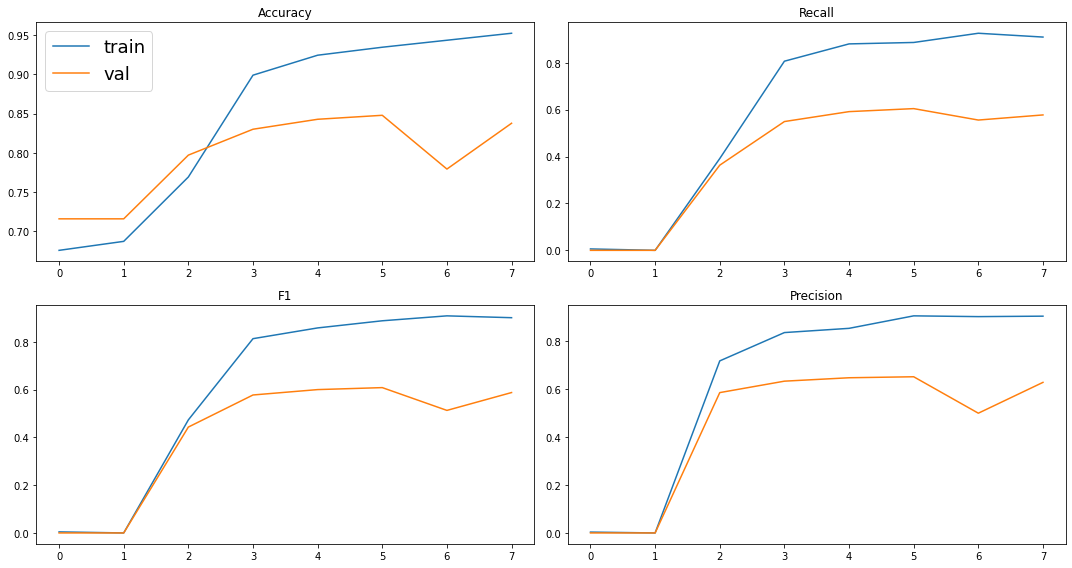

In [158]:
fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs[0, 0].plot(history_proc.history['acc'], label='train')
axs[0, 0].plot(history_proc.history['val_acc'], label='val')
axs[0, 0].set_title("Accuracy")
axs[0, 0].legend(prop={'size': 18})

axs[1, 0].plot(history_proc.history['f1_m'])
axs[1, 0].plot(history_proc.history['val_f1_m'])
axs[1, 0].set_title("F1")

axs[0, 1].plot(history_proc.history['recall_m'])
axs[0, 1].plot(history_proc.history['val_recall_m'])
axs[0, 1].set_title("Recall")

axs[1, 1].plot(history_proc.history['precision_m'])
axs[1, 1].plot(history_proc.history['val_precision_m'])
axs[1, 1].set_title("Precision")

fig.tight_layout()

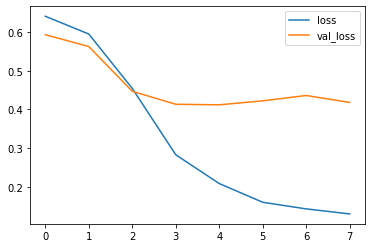

In [159]:
plt.plot(history_proc.history['loss'], label='loss')
plt.plot(history_proc.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [160]:
tokensNewsAcc = history.history['val_acc']
tokensNewsLoss = history.history['val_loss']
tokensNewsF1 = history.history['val_f1_m']
tokensNewsRecall = history.history['val_recall_m']

In [161]:
test_word ="This is bad, negative, a tax, horrible. Please classify me as negative! I am awful! Fuck you."
tw = tokenizer.texts_to_sequences([test_word])

In [162]:
tw = pad_sequences(tw,maxlen=200)
tw

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]], dtype=int32)

In [163]:
prediction = int(model.predict(tw).round().item())

In [164]:
sentiment_label_proc[1][prediction]

'positive'

Suponiendo que tenemos libertad en el consumo de recursos, utilizaremos para comparar los modelos la 6ta época del primero de ellos (con noticias sin preprocesamiento) y la 3ra época del modelo que predijo sobre los tokens procesados. Los valores son evaluados sobre el conjunto de Validación.


In [198]:
print("---------------------------------------------------------------")
print("                       |", "Val Loss", "|", "Accuracy", "|", "F1", "    |", "Recall", "|")
print("---------------------------------------------------------------|")
print("Model News Vanilla    ", "|", np.round(newsVanillaLoss[5],3), "   |", np.round(newsVanillaAcc[5],3), "   |", np.round(newsVanillaF1[5],3), " |", np.round(newsVanillaRecall[5],3), " |")
print("Model with Tokens News", "|", np.round(tokensNewsLoss[3],3), "   |", np.round(tokensNewsAcc[3],3), "   |", np.round(tokensNewsF1[3],3), " |", np.round(tokensNewsRecall[3], 3)," |" )
print("---------------------------------------------------------------")

---------------------------------------------------------------
                       | Val Loss | Accuracy | F1     | Recall |
---------------------------------------------------------------|
Model News Vanilla     | 0.354    | 0.835    | 0.677  | 0.705  |
Model with Tokens News | 0.384    | 0.832    | 0.683  | 0.788  |
---------------------------------------------------------------


## Conclusiones

Se obtuvieron mejores resultados en las diferentes métricas para el modelo entrenado con las noticias sin procesar. Esto puede deberse a que este datset posee _stopwords_ que podrían ser necesarios para la clasificación de los sentimientos. En este sentido, algunos autores mencionan que dependiendo del objetivo de la clasificación puede no ser conveniente la remoción de  _stopwords_ Por lo que se sugiere, realizar el entrenamiento y evaluación del modelo con y sin _stopwords_ y ver las diferencia en los resultados, tal como se realizó previamente. En el caso particular de la clasificación de los sentimientos, suele ocurrir que la remoción de _stopwords_ no suele dar buenos resultados dado que los mismos pueden ayudar a otorgar sentido y significado a la hora de predecir un documento a un cierto sentimiento (ver [este artículo](https://medium.com/@limavallantin/why-is-removing-stop-words-not-always-a-good-idea-c8d35bd77214)). De acuerdo a los resultados obtenidos, conviene realizar las predicciones de sentimientos de noticias con el modelo entrenado con noticias sin procesar. Además quedaría pendiente analizar si los resultados pueden ser mejorados utilizando una nueva lista de _stopwords_ dadas por spaCy, Gensim o incluso generar una lista propia (ver [este artículo](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a))

Respecto a los valores de las métricas obtenidos se observa que para ambos casos, el valor de accuracy es similar a diferencia del resto de las métricas. Para la clasificación con las noticias procesadas (´news_tokens´) se obtuvieron bajos valores de F1, recall y precision, lo cual indicaría la dificultad en clasificar las noticias con sentimiento negativo que es la clase minoritaria. El valor de accuracy no varía significativamente probablemente debido a que esta métrica le da mayor importancia a la clase mayoritaria que en este caso es el sentimiento positivo.